# Определение возраста покупателей

<h1>Содержание<span class="tocSkip"></span></h1><div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский анализ данных" data-toc-modified-id="Исследовательский анализ данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение модели" data-toc-modified-id="Обучение модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ обученной модели" data-toc-modified-id="Анализ обученной модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист</a></span></li><li><span><a

<h1>Описание проекта<span class="tocSkip"></span></h1>

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В качестве исходных данных имеется набор фотографий людей с указанием возраста.

<h1>План выполнения<span class="tocSkip"></span></h1>

- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитайте её качество.

Выполним загрузку необходимых библиотек:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, 
                                     Conv2D, Flatten, AvgPool2D, MaxPooling2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Исследовательский анализ данных

Загрузим CSV-файл для проведения исследовательского анализа данных о возрасте людей:

In [2]:
df=pd.read_csv('/datasets/faces/labels.csv')

В целях пороверки корректности загрузки, выведем первые 15 строк загруженного датасета:

In [3]:
df.head(15)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


Датасет отображается корректно

Выведем общую информацию о датасете:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Как видно из таблицы выше, форматы данных датасета корректные, пропуски в данных отсутствуют. Датасет содержит 7591 объект.

Проверим датасет на наличие явных дубликатов:

In [5]:
df.duplicated().sum()

0

Явные дубликаты отсутствуют

Рассмотрим основные статстические характеристики и визуализацию распределения возраста людей, изображенных на исследуемых фотографиях. Для этого воспользуемся функцией num_stat_and_graph:

In [6]:
def num_stat_and_graph(df, col, n, title, title_x, title_y):
    stat = df[col].describe()
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    sns.histplot(df[col], bins=n, ax=axes[0])
    sns.boxplot(data=df, x=col)
    fig.suptitle(title);
    axes[0].set_xlabel(title_x);
    axes[0].set_ylabel(title_y);
    axes[1].set_xlabel(title_x);
    axes[1].set_ylabel(title_y);
    return stat

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

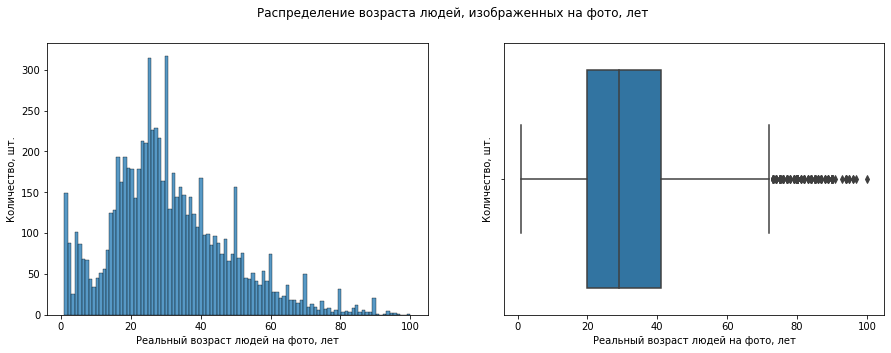

In [7]:
num_stat_and_graph(
    df, 
    'real_age', 
    100, 
    'Распределение возраста людей, изображенных на фото, лет',
    'Реальный возраст людей на фото, лет',
    'Количество, шт.')

Как видно из графика и таблицы выше распределение возраста людей изображенных на фото находится в диапазоне от 1 до 100 лет, со средним значением 31.2 года и медианным значением в 29 лет. Как видно из визуализации, "ящик с усами" счиает значения 70+ выбросами, однако нет реальных оснований так считать, так как это вполне реальные значения возраста, с учетом того что частота их встречаемости в датасете невысока.

Выведем первые 15 фотографий, для этого воспользуемся загрузчиком ImageDataGenerator:

In [8]:
photo = ImageDataGenerator(rescale=1/255)

photo_flow = photo.flow_from_dataframe(dataframe=df,
                                       directory='/datasets/faces/final_files/',
                                       x_col='file_name',
                                       y_col='real_age',
                                       batch_size=15,
                                       class_mode='raw',
                                       seed = 42)

Found 7591 validated image filenames.


In [9]:
features, target = next(photo_flow)

Т.к. в исходных данных эта информация отсутствует, выведем размерность изображений в батче:

In [10]:
features.shape

(15, 256, 256, 3)

Как видно из вывода выше, каждое изображение представляет собой изображение размером 256x256

Выведем первые 15 фотографий из первого батча:

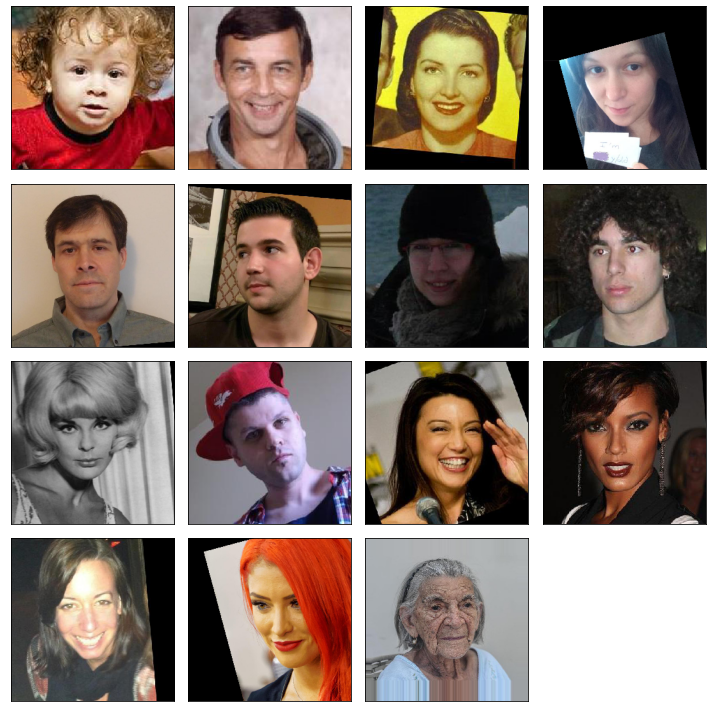

In [11]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Как видно на изображениях выше, на фото действительно отображены люди разного возраста от детей до пожилых людей, фото выполнено в разных цветовых градиентах, с разной контрастностью и яркостью, также некоторые изображения имеют поворот относительно вертикальной оси.

**Вывод:** В рамках данного раздела:
- успешно загружены изучаемые данные;
- выполнен вывод файла CSV, а также 15 фотографий датасета. Данные выводятся корректно.
- датасет собержит 7591 объект
- датсет не содержит пропусков
- датасет не содержит явных дубликатов
- установлено что распределение возраста людей изображенных на фото находится в диапазоне от 1 до 100 лет, со средним значением 31.2 года и медианным значением в 29 лет. Выбросы и аномалии не обнаружены.
- при визуальном изучении 15-ти выведенных изображений, установлено что на фото действительно отображены люди разного возраста от детей до пожилых людей, фото выполнено в разных цветовых градиентах, с разной контрастностью и яркостью, также некоторые изображения имеют поворот относительно вертикальной оси. 

## Обучение модели

В качестве обучающей модели будем использовать сверточную нейронную сеть на базе ResNet50 с использованием GlobalAveragePooling2D в качестве пулинга и Adam в качестве оптимизатора и скоростью обучения learning_rate=0.00005:

```python

import tensorflow 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

SEED = 42
tensorflow.random.set_seed(SEED)
np.random.seed(SEED)

def load_train(path):
    train_datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.25,
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=(path + 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=15,
        class_mode='raw',
        subset='training',
        seed = SEED)
    
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.25
    )
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=(path + 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=15,
        class_mode='raw',
        subset='validation',
        seed = SEED)
    
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.00005)
    backbone=ResNet50(input_shape=input_shape,
                      weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                      include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=(test_data),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model 

```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 380 steps, validate for 127 steps
Epoch 1/10
2025-01-17 14:02:53.106671: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-01-17 14:02:53.438141: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
380/380 - 60s - loss: 226.6214 - mae: 10.9500 - val_loss: 938.0499 - val_mae: 25.7888
Epoch 2/10
380/380 - 49s - loss: 66.7654 - mae: 6.3020 - val_loss: 112.5951 - val_mae: 8.1390
Epoch 3/10
380/380 - 49s - loss: 37.3377 - mae: 4.7333 - val_loss: 74.1424 - val_mae: 6.6411
Epoch 4/10
380/380 - 48s - loss: 27.2284 - mae: 4.0576 - val_loss: 70.5262 - val_mae: 6.3993
Epoch 5/10
380/380 - 48s - loss: 20.9151 - mae: 3.5194 - val_loss: 72.3480 - val_mae: 6.5246
Epoch 6/10
380/380 - 48s - loss: 14.9233 - mae: 2.9517 - val_loss: 72.7472 - val_mae: 6.4074
Epoch 7/10
380/380 - 48s - loss: 12.8834 - mae: 2.7387 - val_loss: 77.0907 - val_mae: 6.6017
Epoch 8/10
380/380 - 48s - loss: 10.9478 - mae: 2.4945 - val_loss: 72.9750 - val_mae: 6.5103
Epoch 9/10
380/380 - 49s - loss: 9.6361 - mae: 2.3283 - val_loss: 88.5568 - val_mae: 7.0618
Epoch 10/10
380/380 - 49s - loss: 9.1365 - mae: 2.3015 - val_loss: 69.0340 - val_mae: 6.4534

127/127 - 12s - loss: 69.0340 - mae: 6.4534
Test MAE: 6.4534

```

## Анализ обученной модели

Для определения возраста покупателей по фото была обучена сверточную нейронную сеть на базе предобученной сети ResNet50 с использованием GlobalAveragePooling2D в качестве пулинга и Adam в качестве оптимизатора и скоростью обучения learning_rate=0.00005. По итогам обучения данная сеть может предсказывать возраст клиента со средней абсолютной ошибкой MAE = 6.45 года, что достаточно для цели Заказчика делать клиенту персонализированные предложения в зависимости от возраста, но не подходит для целей контроля добросовестности кассиров при продаже алкоголя, т.к. 18-ти летний клиент может быть оценен моделью и как 12-ти летний и как 24-х летний человек. 

## Общий вывод

 В рамках решения задачи о предсказании возраста клиента по фото, было выполнено:
- успешно загружены изучаемые данные;
- выполнен вывод файла CSV, а также 15 фотографий датасета. Данные выводятся корректно.
- датасет собержит 7591 объект
- датсет не содержит пропусков
- датасет не содержит явных дубликатов
- установлено что распределение возраста людей изображенных на фото находится в диапазоне от 1 до 100 лет, со средним значением 31.2 года и медианным значением в 29 лет. Выбросы и аномалии не обнаружены.
- при визуальном изучении 15-ти выведенных изображений, установлено что на фото действительно отображены люди разного возраста от детей до пожилых людей, фото выполнено в разных цветовых градиентах, с разной контрастностью и яркостью, также некоторые изображения имеют поворот относительно вертикальной оси.
- для определения возраста покупателей по фото была обучена сверточную нейронную сеть на базе предобученной сети ResNet50 с использованием GlobalAveragePooling2D в качестве пулинга и Adam в качестве оптимизатора и скоростью обучения learning_rate=0.00005. По итогам обучения данная сеть может предсказывать возраст клиента со средней абсолютной ошибкой MAE = 6.45 года, что достаточно для цели Заказчика делать клиенту персонализированные предложения в зависимости от возраста, но не подходит для целей контроля добросовестности кассиров при продаже алкоголя, т.к. 18-ти летний клиент может быть оценен моделью и как 12-ти летний и как 24-х летний человек. 

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы